# Forecasting using ARIMA type methods 
* Guides with codes on https://ranasinghiitkgp.medium.com/time-series-forecasting-using-lstm-arima-moving-average-use-case-single-multi-variate-with-code-5dd41e32d1fc
* Here we try out and compare different forecasting methods:
  * Moving average
  * Linear regression
  * K-nearest neighbours
  * ARIMA
  * LSTM (long short term memory)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# install and import necessary packages 

!pip install geopandas rtree &> /dev/null 

import geopandas as gpd
import pandas as pd
import numpy as np
import rtree
import os
import pickle
import matplotlib.pyplot as plt

print(os.getcwd())

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/shared/ssc22-case-comp/dataset


In [ ]:
## Load the source data
os.chdir('/content/drive/MyDrive/shared/ssc22-case-comp/dataset/')
with open('./canada-avg-by-csd-combined.p', 'rb') as file:
  data = pickle.load(file)

data.head(5)

,CSDUID,PRUID,CDUID,CSDTYPE,geometry,avg_d_mbps,avg_u_mbps,avg_lat_ms,tests,devices,DA_POP,time,conn_type
0,6101017,61,6101,T,"POLYGON ((-133.48192 68.32845, -133.44690 68.3...",14.831457,6.289283,36.847826,46,16,NaN,2019-03-31,fixed
1,6101025,61,6101,HAM,"POLYGON ((-134.99221 68.22099, -134.99302 68.2...",13.439500,1.481000,26.000000,2,2,NaN,2019-03-31,fixed
2,6101036,61,6101,HAM,"POLYGON ((-132.94668 69.40747, -132.94669 69.3...",5.038000,1.317000,54.000000,1,1,NaN,2019-03-31,fixed
3,6102005,61,6102,HAM,"POLYGON ((-125.49035 64.95092, -125.46781 64.9...",13.896667,1.281667,25.666667,3,2,NaN,2019-03-31,fixed
4,6102007,61,6102,T,"POLYGON ((-126.62243 65.27435, -126.62321 65.2...",28.425000,3.389514,28.783784,37,13,NaN,2019-03-31,fixed


Text(0.5, 1.0, 'download speed trend over time for CSD=4806016')

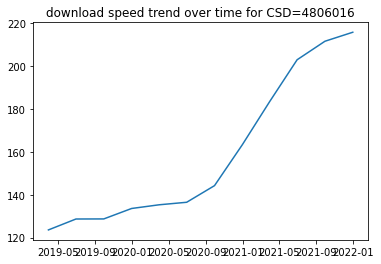

In [65]:
## Take only one CSD (PRUID=48 (Alberta) and conn_type = 'fixed') as an example.

ab_data = data[(data['PRUID'] == '48') & (data['conn_type'] == 'fixed')]

# ab_data1 = ab_data.sort_values(by='tests', ascending=False)
# csd = '4806016'

ab_data2 = ab_data[ab_data['CSDUID']=='4806016'].sort_values(by='time')
plot_x = ab_data2['time']
plot_y = ab_data2['avg_d_mbps']

plt.plot(plot_x, plot_y)
plt.title('download speed trend over time for CSD={csd}'.format(csd = 4806016))

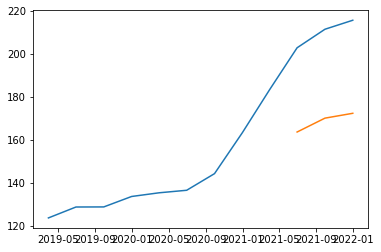

In [66]:
## Moving averages

## create a subset that only contains avg_d_mbps and time
test = ab_data2[['avg_d_mbps', 'time']]

train_set = test.iloc[0:9] # the first 10 observations
val_set = test.iloc[-3:] # the last two observations

preds = []
for i in range(0,val_set.shape[0]):
    a = train_set['avg_d_mbps'][len(train_set)-len(val_set)+i:].sum() + sum(preds)
    b = a/len(val_set)
    preds.append(b)

pred_df = val_set
pred_df['pred'] = preds

pred_df
plt.plot(plot_x, plot_y)
plt.plot(pred_df['time'], pred_df['pred'])

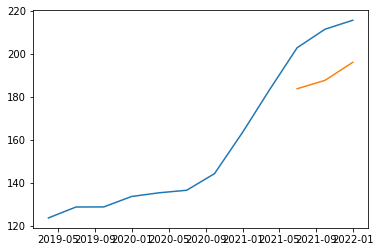

In [82]:
## Linear regression

### Prepare data
data_lin = ab_data.copy()[['CSDUID', 'tests', 'time', 'devices', 'avg_d_mbps']]
data_lin = data_lin[data_lin['CSDUID']=='4806016'][['tests', 'time', 'devices', 'avg_d_mbps']]

### Make features? (like, make time a numerical variable?)
times = sorted(data_lin['time'].unique())
time_ints = [*range(1,len(times)+1)]
data_lin['time_int'] = data_lin['time'].replace(to_replace=times, value = time_ints)

### Split train, val data
train_set = data_lin.iloc[0:-3]
x_train = train_set.drop(columns=['time', 'avg_d_mbps'])
y_train = train_set[['avg_d_mbps']]

val_set = data_lin.iloc[-3:]
x_valid = val_set.drop(columns=['time', 'avg_d_mbps'])
y_valid = val_set[['avg_d_mbps']]

### Implement linear regression
from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(x_train,y_train)

### make predictions
preds = model.predict(x_valid)

pred_df = val_set
pred_df['pred'] = preds

pred_df
plt.plot(plot_x, plot_y)
plt.plot(pred_df['time'], pred_df['pred'])

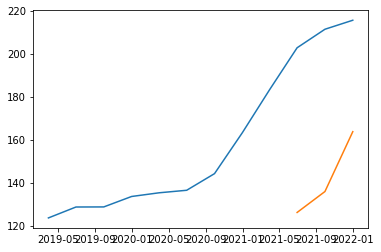

In [83]:
## k-Nearest Neighbours
from sklearn import neighbors
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))

#scaling data
x_train_scaled = scaler.fit_transform(x_train)
x_train = pd.DataFrame(x_train_scaled)
x_valid_scaled = scaler.fit_transform(x_valid)
x_valid = pd.DataFrame(x_valid_scaled)

#using gridsearch to find the best parameter
params = {'n_neighbors':[2,3,4,5,6,7,8,9]}
knn = neighbors.KNeighborsRegressor()
model = GridSearchCV(knn, params, cv=5)

#fit the model and make predictions
model.fit(x_train,y_train)
preds = model.predict(x_valid)

pred_df = val_set
pred_df['pred'] = preds

pred_df
plt.plot(plot_x, plot_y)
plt.plot(pred_df['time'], pred_df['pred'])

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=57.021, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=58.627, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=56.280, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=55.796, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=62.294, Time=0.01 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=nan, Time=0.06 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=nan sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=inf, Time=0.05 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0] intercept
Total fit time: 0.438 seconds


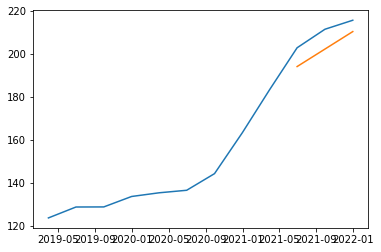

In [87]:
## Auto ARIMA

!pip install pmdarima &> /dev/null

from pmdarima.arima import auto_arima

# plug in some random parameter values
model = auto_arima(y_train, 
                   start_p=1, 
                   start_q=1,
                   max_p=3, 
                   max_q=3, 
                   m=12,
                   start_P=0, 
                   seasonal=False,
                   d=1, 
                   D=0, 
                   trace=True,
                   error_action='ignore',
                   suppress_warnings=True
                   )
model.fit(y_train)

forecast = model.predict(n_periods=3)
forecast = pd.DataFrame(forecast,index = y_valid.index,columns=['Prediction'])

pred_df = val_set
pred_df['pred'] = forecast

plt.plot(plot_x, plot_y)
plt.plot(pred_df['time'], pred_df['pred'])

In [ ]:
data['time1'] = data['time'].dt.strftime('%Y-%m')  ## convert datetime format to string since geopandas cannot take datetime format column.
data = data.drop(columns = ['time'])

data1 = data[(data['time1'] == '2019-03') & (data['conn_type']=='fixed')] ## extract the first time point as an experimental set.
data1.shape

## convert pandas to geopandas df
geo_data1 = gpd.GeoDataFrame(data1, geometry='geometry')
geo_data1 = geo_data1.set_crs(4326, allow_override=True)

geo_data1.plot()

(3649, 13)